In [1]:
# python env: modnenv_v2

import os
import string
import random
import numpy as np
from sklearn.model_selection import KFold
from pathlib import Path
import matplotlib.pyplot as plt
import json 
import pandas as pd
from copy import deepcopy
from modnet.models import EnsembleMODNetModel
from modnet.preprocessing import MODData
from modnet.hyper_opt import FitGenetic
from monty.serialization import dumpfn, loadfn
from pymatgen.ext.matproj import MPRester
from pymatgen.core.structure import Structure
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from scipy.stats import spearmanr
from IPython.display import Image
from tqdm import tqdm
import pickle
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2024-01-12 05:33:31.270372: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-12 05:33:31.272151: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-12 05:33:31.294958: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-12 05:33:31.294985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-12 05:33:31.295938: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Loading previous cycle

Let's load the outputs of the previous selected compounds and recover all the relevant data into one dataframe

In [2]:
outprev_json_path = (Path('..') / 'v1' / 'outputs_selected_v1.json')
outprev_df_path = (Path('.') / 'df_outputs_v2.pkl')


if outprev_df_path.exists():
    with open(outprev_df_path, 'rb') as f:
        df_outputs = pickle.load(f)
else:
    # read file
    with open(outprev_json_path, 'r') as myfile:
        data=myfile.read()

    # parse file
    obj = json.loads(data)


    out_mp_id = []
    out_eps_stat = [] #epsilon_ij_static
    out_ref_indices = [] #n1,n2, and n3 as sqrt(eps_ii)
    out_ref_index = [] #avg(n1, n2, n3)
    out_structure = []
    for o in obj:
        out_mp_id.append(o['metadata']["mp-id"])
        eps_ij = np.array(o['output']["calcs_reversed"][0]["output"]["epsilon_static"])
        out_eps_stat.append(eps_ij)
        try:
            out_ref_indices.append((eps_ij**0.5).diagonal())
            out_ref_index.append(np.trace(eps_ij**0.5)/3)
        except TypeError:
            out_ref_indices.append(np.nan)
            out_ref_index.append(np.nan)

        out_structure.append(o['output']["calcs_reversed"][0]["input"]["structure"])


    df_outputs = pd.DataFrame()
    df_outputs['eps_stat'] = out_eps_stat
    df_outputs['refractive_indices'] = out_ref_indices
    df_outputs['refractive_index'] = out_ref_index
    df_outputs['structure'] = out_structure
    df_outputs.index = out_mp_id


    with open('../v0/df_mp_2023_feat_filtered.pkl', 'rb') as f:
        df_mp_2023_feat_filtered = pickle.load(f)
    df_mp_2023_feat_filtered.shape


    # Load MP 2023 structures, bandgap, ehull
    path_structures_mp_2023 = (
        Path("./../../../") / "re2fractive_onedrive" / "data" / "mp2023_structures.json"
    )

    with open(path_structures_mp_2023, "r") as f:
        strucs_mp = json.load(f)

    # Filter the MP docs to remove Naccarato's dataset and the materials with refractive index
    strucs_mp_filt = [doc for doc in strucs_mp if doc["id"] in df_mp_2023_feat_filtered.index.values.flatten()]

    # Reorder the MP docs to match the order of the filtered MP MODData 
    strucs_mp_filt_odd = sorted(strucs_mp_filt, key=lambda x: list(df_mp_2023_feat_filtered.index.values.flatten()).index(x['id']))


    gap_out = []
    id_out = []
    for struc in strucs_mp_filt_odd:
        if struc['id'] in df_outputs.index.values:
            gap_out.append(struc['attributes']["_mp_band_gap"])
            id_out.append(struc['id'])

    zipped = zip(gap_out, id_out)
    gap_out_sorted = [g for g, i in sorted(zipped, key=lambda x: list(df_outputs.index.values.flatten()).index(x[1]))]

    df_outputs['bandgap'] = gap_out_sorted

    with open(outprev_df_path, 'wb') as f:
        pickle.dump(df_outputs, f)


print(df_outputs.shape)

(153, 5)


Let's visualize the outputs

In [3]:
# Load MP 2023 structures, bandgap, ehull
path_structures_naccarato = (
    Path("./../../../") / "re2fractive_onedrive" / "data" / "structures.json"
)
with open(path_structures_naccarato, "r") as f:
    strucs_naccarato = json.load(f)

In [4]:
import plotly.express as px
import plotly.graph_objects as go

gap_naccarato = [strucs_naccarato[mpid]["attributes"]["_naccarato_gga_bandgap"] for mpid in strucs_naccarato]
refractive_index_naccarato = [strucs_naccarato[mpid]["attributes"]["_naccarato_refractive_index"] for mpid in strucs_naccarato]

# Data
data_naccarato = {'x': gap_naccarato, 'y': refractive_index_naccarato}
data_outputs = {'x': df_outputs['bandgap'], 'y': df_outputs['refractive_index']}

# Scatter plot for Nacc.
scatter_naccarato = go.Scatter(
    x=data_naccarato['x'],
    y=data_naccarato['y'],
    mode='markers',
    marker=dict(symbol='x'),
    name='Nacc.'
)

# Scatter plot for MP pred.
scatter_mp_pred = go.Scatter(
    x=data_outputs['x'],
    y=data_outputs['y'],
    mode='markers',
    # error_y=data_outputs['error_y'],
    # marker='.',
    # line=dict(color='darkorange'),
    name='v1 outputs',
    text=[mpid for mpid in df_outputs.index.values]
)

# Layout
layout = go.Layout(
    title=dict(text='Scatter Plot'),
    xaxis=dict(title='$E_g$ (eV)', showgrid=True),
    yaxis=dict(title='$n$', showgrid=True),
    legend=dict(font=dict(size=12))
)

# Create figure
fig = go.Figure(data=[scatter_naccarato, scatter_mp_pred], layout=layout)

# Show figure
fig.show()

Let's remove the instances with NaN and potential outliers

In [5]:
outprev_df_filtout_path = (Path('.') / 'df_outputs_filtout_v2.pkl')
lim_up   = 8
lim_down = 1.001

if outprev_df_filtout_path.exists():
    with open(outprev_df_filtout_path, 'rb') as f:
        df_outputs_filtout = pickle.load(f)
else:
    # NaN
    df_outputs = df_outputs.dropna()


    # Outliers
    outliers = df_outputs[(df_outputs['refractive_index']>lim_up) | (df_outputs['refractive_index']<=lim_down)]
    # display(outliers)

    gap_outliers = []
    id_outliers = []
    for struc in strucs_mp_filt_odd:
        if struc['id'] in outliers.index.values:
            gap_outliers.append(struc['attributes']["_mp_band_gap"])
            id_outliers.append(struc['id'])

    display(outliers)
    print(id_outliers)
    print(gap_outliers)

    for index, row in outliers.iterrows():
        s = Structure.from_dict(row['structure'])
        print(s.formula)
        print(row['refractive_index'])

    df_outputs_filtout = df_outputs.drop(outliers.index.values)

    with open(outprev_df_filtout_path, 'wb') as f:
        pickle.dump(df_outputs_filtout, f)


print(df_outputs_filtout.shape)

(138, 5)


Let's see how well the previous model predicted the newly acquired outputs

In [6]:
with open('../v1/results_mp_v1.pkl', 'rb') as f:
    results_pred_prev, results_unc_prev = pickle.load(f)

results_pred_prev = results_pred_prev.filter(items=df_outputs_filtout.index.values, axis=0)
results_unc_prev = results_unc_prev.filter(items=df_outputs_filtout.index.values, axis=0)

MAE = 0.4105684326498361
RMSE = 0.32742428985035177
Rho_sp = 0.959784378146483


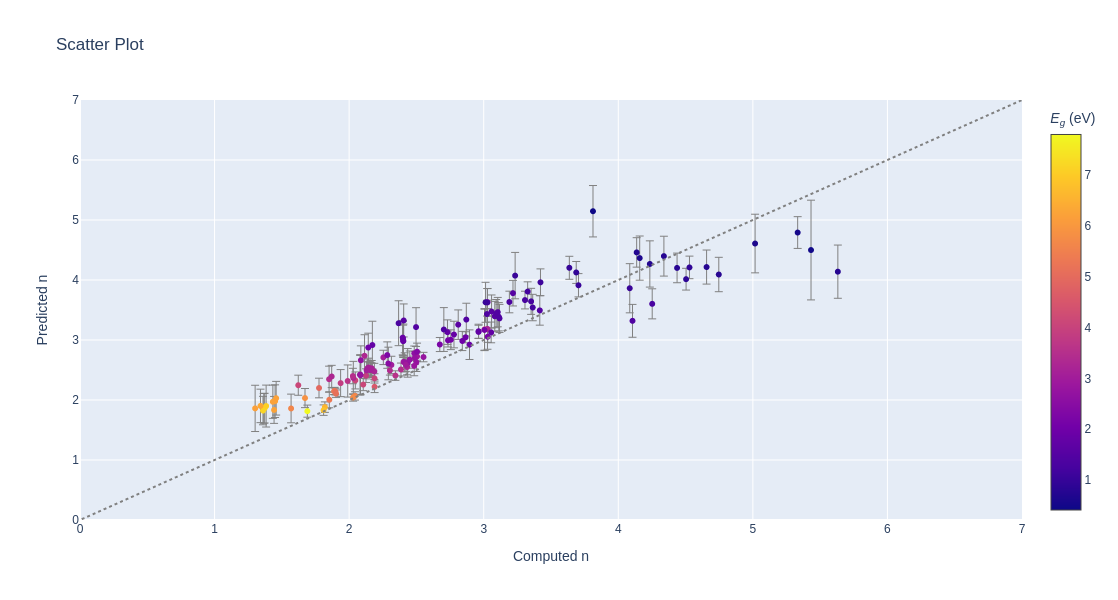

In [7]:
# Data
data_prev_outputs = {'x': df_outputs_filtout['refractive_index'], 
                     'y': results_pred_prev['refractive_index'], 
                     'error_y': results_unc_prev['refractive_index'],
                     'color': df_outputs_filtout['bandgap']}


mae = mean_absolute_error(data_prev_outputs['x'], data_prev_outputs['y'])
rmse = mean_squared_error(data_prev_outputs['x'], data_prev_outputs['y'])
spearmanrho = spearmanr(data_prev_outputs['x'], data_prev_outputs['y'])
print(f"MAE = {mae}")
print(f"RMSE = {rmse}")
print(f"Rho_sp = {spearmanrho.statistic}")

# Scatter plot for previous outputs.
scatter_outputs_prev = go.Scatter(
    x=data_prev_outputs['x'],
    y=data_prev_outputs['y'],
    mode='markers',
    error_y=dict(
        array=data_prev_outputs['error_y'],
        color='gray',
        thickness=1,
        visible=True,
        ),
    marker=dict(
        color=data_prev_outputs['color'],
        colorbar=dict(
            title="<i>E<sub>g</sub></i> (eV)"
        ),
        colorscale="Plasma"
    ),
    line=dict(color='darkorange'),
    name='v1 outputs',
    showlegend=False,
    text=[mpid for mpid in df_outputs_filtout.index.values]
)

ideal = go.Scatter(
    x=[-100,100],
    y=[-100,100],
    mode="lines",
    line=dict(color='gray', dash='dot'),
    showlegend=False
)

# Layout
layout = go.Layout(
    title=dict(text='Scatter Plot'),
    xaxis=dict(title='Computed n', showgrid=True,  range=[0,7]),
    yaxis=dict(title='Predicted n', showgrid=True, range=[0,7]),
    legend=dict(font=dict(size=12)),
)

# Create figure
fig = go.Figure(data=[scatter_outputs_prev,ideal], layout=layout)

fig.update_layout(
    autosize=False,
    width=600,
    height=600,
    # margin=dict(
    #     l=50,
    #     r=50,
    #     b=100,
    #     t=100,
    #     pad=4
    # ),
    # paper_bgcolor="LightSteelBlue",
)

# Show figure
fig.show()

# Updating to this cycle

In [8]:
modd_nac_prev_path = (Path('..') / 'v1' / 'mod.data_refeatselec_v1')
modd_nac_new_path = (Path('.') / 'mod.data_refeatselec_v2')

if modd_nac_new_path.exists():
    md_naccarato_new = MODData.load(modd_nac_new_path)
else:
    # Load the previous training MODData
    md_naccarato_prev = MODData.load(modd_nac_prev_path)

    with open('../v0/df_mp_2023_feat_filtered.pkl', 'rb') as f:
        df_mp_2023_feat_filtered = pickle.load(f)
    print(df_mp_2023_feat_filtered.shape)

    df_outputs_featurized = df_mp_2023_feat_filtered.filter(items=df_outputs_filtout.index.values, axis=0)\
                                                    .filter(items=md_naccarato_prev.df_featurized.columns.values.flatten(), axis=1)
    print(df_outputs_featurized.shape)

    md_naccarato_new = MODData(
                            df_featurized   = pd.concat([md_naccarato_prev.df_featurized, df_outputs_featurized]),
                        )
    md_naccarato_new.df_targets = pd.concat([md_naccarato_prev.df_targets, df_outputs_filtout.filter(items=['refractive_index'], axis=1)])
    md_naccarato_new.optimal_features = md_naccarato_prev.optimal_features
    md_naccarato_new.optimal_features_by_target = md_naccarato_prev.optimal_features_by_target
    md_naccarato_new.num_classes = md_naccarato_prev.num_classes

    md_naccarato_new.save(modd_nac_new_path)


print(md_naccarato_new.df_featurized.shape)

2024-01-12 05:33:40,941 - modnet - INFO - Loaded <modnet.preprocessing.MODData object at 0x7f5ba4ef5910> object, created with modnet version 0.4.1
(4208, 3019)


# Benchmark

In [9]:
kf = KFold(5, shuffle=True, random_state=42)

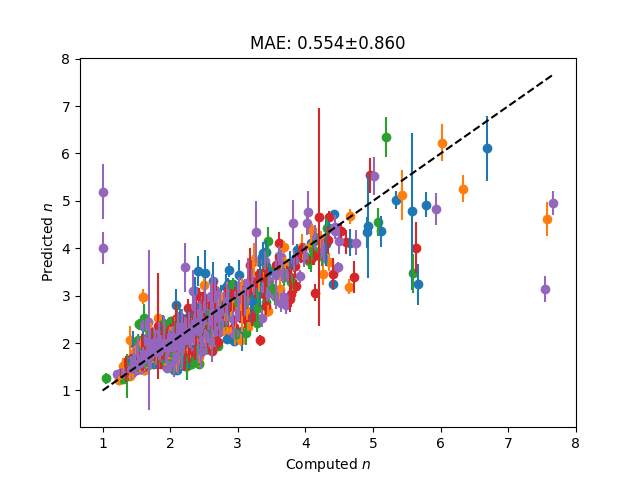

In [10]:
targets = ["refractive_index"]
experiment_name = "GA2_kfold_ensemble-" + "-".join(targets)
scores = []


fig_bk_ntd0_path = (Path(".") / "models" / "fitgenetic_2" / f"{experiment_name}.png")

if fig_bk_ntd0_path.exists():
    fig = Image(filename=fig_bk_ntd0_path)
    display(fig)
else:
    for ind, (train, test) in enumerate(
        kf.split(md_naccarato_new.df_featurized, y=md_naccarato_new.df_targets)
    ):
        train_moddata, test_moddata = md_naccarato_new.split((train, test))
        model_path = (
            Path(".") / "models" / "fitgenetic_2" / f"{experiment_name}_{ind}.pkl"
        )
        print(model_path)
        if model_path.exists():
            model = EnsembleMODNetModel.load(model_path)

        else:
            ga = FitGenetic(train_moddata)
            model = ga.run(
                size_pop=20, # dflt
                num_generations=10, # dflt
                nested=0, # dflt = 5
                n_jobs=2,
                early_stopping=4, # dflt
                refit=0, # dflt = 5
                fast=False,
            )
            model.save(model_path)

        scores.append(model.evaluate(test_moddata))

        predictions, uncertainties = model.predict(test_moddata, return_unc=True)

        plt.scatter(
            test_moddata.df_targets.values.ravel(),
            predictions.values.ravel(),
        )
        plt.errorbar(
            test_moddata.df_targets.values.ravel(),
            predictions.values.ravel(),
            yerr=uncertainties.values.ravel(),
            ls="none",
        )

    print("="*10 + f" {experiment_name} " + "="*10)
    print("Training complete.")
    print("Training complete.")
    print(f"Accuracy: {np.mean(scores):.3f}±{np.std(scores):.3f}")

    plt.plot(
        np.linspace(
            np.min(md_naccarato_new.df_targets.values),
            np.max(md_naccarato_new.df_targets.values),
            3,
        ),
        np.linspace(
            np.min(md_naccarato_new.df_targets.values),
            np.max(md_naccarato_new.df_targets.values),
            3,
        ),
        color="black",
        ls="--",
    )

    plt.ylabel("Predicted $n$")
    plt.xlabel("Computed $n$")
    # plt.xlim((-1,30))
    # plt.ylim((-1,30))
    plt.title(f"MAE: {np.mean(scores):.3f}±{np.std(scores):.3f}")

    plt.savefig(fig_bk_ntd0_path)
    plt.savefig(Path(str(fig_bk_ntd0_path).replace("png", "pdf")))


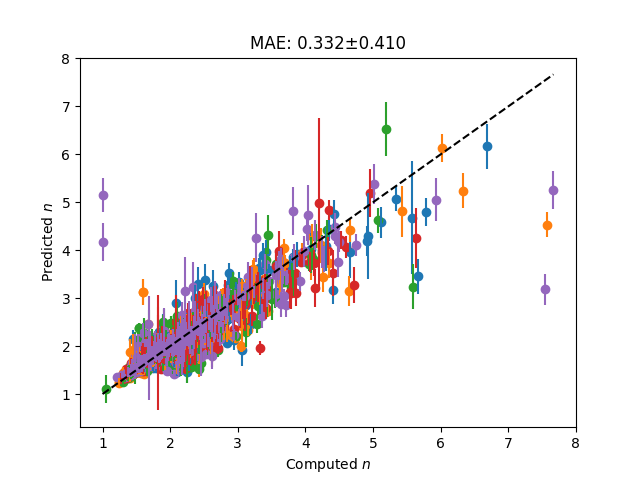

In [12]:
targets = ["refractive_index"]
experiment_name = "GA3_kfold_ensemble-" + "-".join(targets)
scores = []


fig_bk_ntd5_path = (Path(".") / "models" / "fitgenetic_3" / f"{experiment_name}.png")

if fig_bk_ntd5_path.exists():
    fig = Image(filename=fig_bk_ntd5_path)
    display(fig)
else:
    for ind, (train, test) in enumerate(
        kf.split(md_naccarato_new.df_featurized, y=md_naccarato_new.df_targets)
    ):
        train_moddata, test_moddata = md_naccarato_new.split((train, test))
        model_path = (
            Path(".") / "models" / "fitgenetic_3" / f"{experiment_name}_{ind}.pkl"
        )
        print(model_path)
        if model_path.exists():
            model = EnsembleMODNetModel.load(model_path)
    
        else:
            ga = FitGenetic(train_moddata)
            model = ga.run(
                size_pop=20, # dflt
                num_generations=10, # dflt
                nested=5, # dflt = 5
                n_jobs=2,
                early_stopping=4, # dflt
                refit=0, # dflt = 5
                fast=False,
            )
            model.save(model_path)
    
        scores.append(model.evaluate(test_moddata))
    
        predictions, uncertainties = model.predict(test_moddata, return_unc=True)
    
        plt.scatter(
            test_moddata.df_targets.values.ravel(),
            predictions.values.ravel(),
        )
        plt.errorbar(
            test_moddata.df_targets.values.ravel(),
            predictions.values.ravel(),
            yerr=uncertainties.values.ravel(),
            ls="none",
        )
    
    print("="*10 + f" {experiment_name} " + "="*10)
    print("Training complete.")
    print("Training complete.")
    print(f"Accuracy: {np.mean(scores):.3f}±{np.std(scores):.3f}")
    
    plt.plot(
        np.linspace(
            np.min(md_naccarato_new.df_targets.values),
            np.max(md_naccarato_new.df_targets.values),
            3,
        ),
        np.linspace(
            np.min(md_naccarato_new.df_targets.values),
            np.max(md_naccarato_new.df_targets.values),
            3,
        ),
        color="black",
        ls="--",
    )
    
    plt.ylabel("Predicted $n$")
    plt.xlabel("Computed $n$")
    plt.title(f"MAE: {np.mean(scores):.3f}±{np.std(scores):.3f}")

    plt.savefig(fig_bk_ntd5_path)
    plt.savefig(Path(str(fig_bk_ntd5_path).replace("png", "pdf")))


# Production

## Training on the whole dataset

In [12]:
targets = ["refractive_index"]
experiment_name = "GA_Rf0_Nstd0-" + "-".join(targets)
scores = []

model_path = (
    Path(".") / "models" / "production" / f"{experiment_name}_prod_v2.pkl"
)

if model_path.exists():
    model = EnsembleMODNetModel.load(model_path)

else:
    ga = FitGenetic(md_naccarato_new)
    model = ga.run(
        size_pop=20, # dflt
        num_generations=10, # dflt
        nested=0, # dflt = 5
        n_jobs=4,
        early_stopping=4, # dflt
        refit=0, # dflt = 5
        fast=False,
    )
    model.save(model_path)

2024-01-09 09:04:51,778 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f5bc046d220> object, created with modnet version 0.4.1


In [11]:
targets = ["refractive_index"]
experiment_name = "GA_Rf0_Nstd5-" + "-".join(targets)
scores = []

model_path = (
    Path(".") / "models" / "production" / f"{experiment_name}_prod_v2.pkl"
)

if model_path.exists():
    model = EnsembleMODNetModel.load(model_path)

else:
    ga = FitGenetic(md_naccarato_new)
    model = ga.run(
        size_pop=20, # dflt
        num_generations=10, # dflt
        nested=5, # dflt = 5
        n_jobs=2,
        early_stopping=4, # dflt
        refit=0, # dflt = 5
        fast=False,
    )
    model.save(model_path)

2024-01-11 10:08:03,393 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f3902429bb0> object, created with modnet version 0.4.1


## Preparing the MP for prediction

In [14]:
moddmp_path = (
    Path(".") / "mod.data_mp2023_filtered_v2"
)

df_outputs_prev_paths = [
    (Path('..') / 'v1' / 'df_outputs_v1.pkl'),  # v1 - stopped by accident -> retry the non-finished
    (Path('.') / 'df_outputs_v2.pkl'),          # v2 - Lucia failure       -> retry the non-finished
]


if moddmp_path.exists():
    # Load the prepared (filtered) MP MODData
    md_mp_filt = MODData.load(moddmp_path)
else:
    with open('../v0/df_mp_2023_feat_filtered.pkl', 'rb') as f:
        df_mp_2023_feat_filtered = pickle.load(f)
    print(df_mp_2023_feat_filtered.shape)

    with open(df_outputs_prev_paths[0], 'rb') as f:
        df_outputs_prevs = pickle.load(f)
    print(df_outputs_prevs.shape)
    for path in df_outputs_prev_paths[1:]:
        with open(path, 'rb') as f:
            df_tmp = pickle.load(f)
        print(df_tmp.shape)
        df_outputs_prevs = pd.concat([df_outputs_prevs, df_tmp])


    df_mp_2023_feat_filtered = df_mp_2023_feat_filtered.drop(index=df_outputs_prevs.index.values)
    print(df_mp_2023_feat_filtered.shape)


    # Load MP 2023 structures, bandgap, ehull
    path_structures_mp_2023 = (
        Path("./../../../") / "re2fractive_onedrive" / "data" / "mp2023_structures.json"
    )
    with open(path_structures_mp_2023, "r") as f:
        strucs_mp = json.load(f)

    # Filter the MP docs to remove Naccarato's dataset and the materials with refractive index
    strucs_mp_filt = [doc for doc in strucs_mp if doc["id"] in df_mp_2023_feat_filtered.index.values.flatten()]

    # Reorder the MP docs to match the order of the filtered MP MODData 
    strucs_mp_filt_odd = sorted(strucs_mp_filt, key=lambda x: list(df_mp_2023_feat_filtered.index.values.flatten()).index(x['id']))

    print(len(strucs_mp_filt_odd))


    # Recover a dataframe of Pymatgen Structures from the optimade docs
    from optimade.adapters import Structure as optim_Structure
    df_mp_structures = pd.DataFrame.from_dict(
        {doc["id"]: {"structure": optim_Structure(doc).as_pymatgen} for doc in strucs_mp_filt_odd}, orient="index"
    )

    # Instantiate a MODData for the filtered MP
    md_mp_filt = MODData(
        materials=df_mp_structures['structure'],
        df_featurized = df_mp_2023_feat_filtered,
        structure_ids=df_mp_2023_feat_filtered.index.values.flatten(),
    )
    md_mp_filt.save(moddmp_path)

print(md_mp_filt.df_featurized.shape)

2024-01-11 10:28:15,076 - modnet - INFO - Loaded <modnet.preprocessing.MODData object at 0x7f38e47395e0> object, created with modnet version 0.4.1
(23957, 4565)


In [23]:
results_path = (
    Path(".") / "results_mp_v2.pkl"
)

if results_path.exists():
    with open(results_path, 'rb') as f:
        results = pickle.load(f)
else:
    # Predict the filtered MP
    results = model.predict(md_mp_filt, return_unc=True)

    with open(results_path, 'wb') as f:
        pickle.dump(results, f)


# Recover the predictions and the associated uncertainties
predictions, uncertainties = results

## Vis. n-Eg

#### Recover Naccarato dataset bandgap

In [24]:
# Load MP 2023 structures, bandgap, ehull
path_structures_naccarato = (
    Path("./../../../") / "re2fractive_onedrive" / "data" / "structures.json"
)
with open(path_structures_naccarato, "r") as f:
    strucs_naccarato = json.load(f)

gap_naccarato = [strucs_naccarato[mpid]["attributes"]["_naccarato_gga_bandgap"] for mpid in strucs_naccarato]
refractive_index_naccarato = [strucs_naccarato[mpid]["attributes"]["_naccarato_refractive_index"] for mpid in strucs_naccarato]

data_naccarato = {'x': gap_naccarato, 'y': refractive_index_naccarato}

#### Recover computer candidates

In [25]:
outprev_df_filtout_paths = [
    (Path('..') / 'v1' / 'df_outputs_filtout_v1.pkl'),
    (Path('.') / 'df_outputs_filtout_v2.pkl'),
    ]

with open(outprev_df_filtout_paths[0], 'rb') as f:
    df_outputs_filtouts = pickle.load(f)
print(df_outputs_filtouts.shape)
for path in outprev_df_filtout_paths[1:]:
    with open(path, 'rb') as f:
        df_tmp = pickle.load(f)
    print(df_tmp.shape)
    df_outputs_filtouts = pd.concat([df_outputs_filtouts, df_tmp])

print(df_outputs_filtouts.shape)

data_outputs_filtouts = {'x': df_outputs_filtouts['bandgap'], 'y': df_outputs_filtouts['refractive_index']}

(69, 5)
(138, 5)
(207, 5)


#### Recover predicted MP

In [27]:
md_mp_filt = MODData.load(moddmp_path)
    
path_structures_mp_2023 = (
    Path("./../../../") / "re2fractive_onedrive" / "data" / "mp2023_structures.json"
)
with open(path_structures_mp_2023, "r") as f:
    strucs_mp = json.load(f)

# Filter the MP docs to remove Naccarato's dataset and the materials with refractive index
strucs_mp_filt = [doc for doc in strucs_mp if doc["id"] in md_mp_filt.df_featurized.index.values.flatten()]

# Reorder the MP docs to match the order of the filtered MP MODData 
strucs_mp_filt_odd = sorted(strucs_mp_filt, key=lambda x: list(md_mp_filt.df_featurized.index.values.flatten()).index(x['id']))


gap_mp = [struc['attributes']["_mp_band_gap"] for struc in strucs_mp_filt_odd]
refractive_index_mp_pred = predictions.refractive_index.values.flatten()
refractive_index_mp_unc = uncertainties.refractive_index.values.flatten()

data_mp_pred = {'x': gap_mp, 'y': refractive_index_mp_pred, 'error_y': {'array': refractive_index_mp_unc, 'visible': True}}

2024-01-11 10:59:01,190 - modnet - INFO - Loaded <modnet.preprocessing.MODData object at 0x7f38e4799c40> object, created with modnet version 0.4.1


### Vis.

In [29]:
# Scatter plot for Nacc.
scatter_naccarato = go.Scatter(
    x=data_naccarato['x'],
    y=data_naccarato['y'],
    mode='markers',
    marker=dict(symbol='x'),
    name='Nacc.',
    opacity=0.5
)

# Scatter plot for the v0 outputs without the outliers.
scatter_outputs_filtout = go.Scatter(
    x=data_outputs_filtouts['x'],
    y=data_outputs_filtouts['y'],
    mode='markers',
    marker=dict(symbol='x'),
    name='Out. prev.',
    opacity=0.5
)

# Scatter plot for MP pred.
scatter_mp_pred = go.Scatter(
    x=data_mp_pred['x'],
    y=data_mp_pred['y'],
    mode='markers',
    error_y=data_mp_pred['error_y'],
    # marker='.',
    # line=dict(color='darkorange'),
    name='MP pred.',
    text=[struc["id"] for struc in strucs_mp_filt_odd],
    opacity=0.5
)

# Layout
layout = go.Layout(
    title=dict(text='Scatter Plot'),
    xaxis=dict(title='$E_g$ (eV)', showgrid=True),
    yaxis=dict(title='$n$', showgrid=True),
    legend=dict(font=dict(size=12))
)

# Create figure
fig = go.Figure(data=[scatter_naccarato, scatter_outputs_filtout, scatter_mp_pred], layout=layout)

# Show figure
fig.show()

## Selection candidates

First let's put all the necessary information into one dataframe

In [30]:
ehull_mp_filt_odd = [struc['attributes']["_mp_energy_above_hull"] for struc in strucs_mp_filt_odd]
nsites_mp_filt_odd = [struc['attributes']["nsites"] for struc in strucs_mp_filt_odd]

In [31]:
predictions['nsites'] = nsites_mp_filt_odd
predictions['ehull'] = np.array(ehull_mp_filt_odd)
predictions['refractive_index_unc'] = uncertainties['refractive_index'].values
predictions['bandgap'] = gap_mp
predictions['structure'] = [struc.as_dict() for struc, mpid in zip(md_mp_filt.structures, md_mp_filt.structure_ids) if mpid in predictions.index]

Second let's remove the obvious outliers

In [32]:
outliers = ['mp-568145', 'mp-23155', 'mp-111', 'mp-754382', 'mp-23158', 'mp-23156', 'mp-614456']
predictions = predictions.drop(outliers, axis=0)

Third let's put all the necessary information into one dataframe

In [33]:
predictions['fom_energy'] = np.sqrt(predictions['bandgap'])*(predictions['refractive_index']+predictions['refractive_index_unc'])**2
predictions['fom_leak'] = predictions['bandgap']*(predictions['refractive_index']+predictions['refractive_index_unc'])**2

In [34]:
fom_energy_minmax = (predictions['fom_energy']-min(predictions['fom_energy']))/(max(predictions['fom_energy'])-min(predictions['fom_energy']))
fom_leak_minmax = (predictions['fom_leak']-min(predictions['fom_leak']))/(max(predictions['fom_leak'])-min(predictions['fom_leak']))

In [35]:
predictions['avg_fom'] = (fom_energy_minmax+fom_leak_minmax)/2

In [36]:
predictions = predictions[predictions['nsites']<80]
predictions = predictions[predictions['ehull']<0.025] # already satisfied to begin with
predictions

refractive_index  nsites     ehull  refractive_index_unc  bandgap  \
mp-10009            3.192920       8  0.000000              0.111501   0.7853   
mp-1001012          2.153646      14  0.009354              0.207608   0.5768   
mp-1001019          2.467436      14  0.003289              0.192884   1.0918   
mp-1001024          2.244143      14  0.003040              0.145630   1.7768   
mp-1001080          1.532050      12  0.004743              0.092175   5.6848   
...                      ...     ...       ...                   ...      ...   
mp-999471           2.613841       4  0.000000              0.271970   1.8121   
mp-999474           2.529121       4  0.000000              0.166017   1.8867   
mp-999488           2.522986       4  0.000000              0.168485   1.8635   
mp-999489           2.627156       4  0.000000              0.204900   1.3585   
mp-999490           2.214545       4  0.000000              0.095396   2.2856   

                                                    structure  fom_energy  \
mp-10009    {'@module': 'pymatgen.core.structure', '@class...    9.676281   
mp-1001012  {'@module': 'pymatgen.core.structure', '@class...    4.234463   
mp-1001019  {'@module': 'pymatgen.core.structure', '@class...    7.395021   
mp-1001024  {'@module': 'pymatgen.core.structure', '@class...    7.612591   
mp-1001080  {'@module': 'pymatgen.core.structure', '@class...    6.289989   
...                                                       ...         ...   
mp-999471   {'@module': 'pymatgen.core.structure', '@class...   11.210549   
mp-999474   {'@module': 'pymatgen.core.structure', '@class...    9.977304   
mp-999488   {'@module': 'pymatgen.core.structure', '@class...    9.888816   
mp-999489   {'@module': 'pymatgen.core.structure', '@class...    9.348317   
mp-999490   {'@module': 'pymatgen.core.structure', '@class...    8.066810   

             fom_leak   avg_fom  
mp-10009     8.574845  0.185642  
mp-1001012   3.215962  0.064211  
mp-1001019   7.727000  0.147216  
mp-1001024  10.147330  0.171754  
mp-1001080  14.997106  0.197133  
...               ...       ...  
mp-999471   15.090998  0.264536  
mp-999474   13.704545  0.235483  
mp-999488   13.499229  0.232454  
mp-999489   10.895904  0.201914  
mp-999490   12.195565  0.196174  

[20033 rows x 9 columns]

In [37]:
pred_sorted = predictions.sort_values(by=['avg_fom'], ascending=False)

In [40]:
df_selected = pred_sorted.iloc[:200]
df_selected

refractive_index  nsites     ehull  refractive_index_unc  bandgap  \
mp-23005            6.648565      12  0.001198              0.841252   0.4221   
mp-1106025          7.115211      17  0.006531              0.897140   0.3205   
mp-569304           2.230662       4  0.001885              0.646072   4.5566   
mp-994911           1.808056       8  0.010596              1.253004   3.3265   
mp-675543           5.393896       7  0.000000              0.702063   0.4549   
...                      ...     ...       ...                   ...      ...   
mp-1228045          2.170953      52  0.013740              0.120172   3.8545   
mp-1216120          2.366045      36  0.012911              0.105646   3.1677   
mp-1208857          1.900973      28  0.006884              0.082675   5.5384   
mp-5503             2.178080      12  0.004064              0.066737   4.0517   
mp-768728           2.244742      32  0.018803              0.253076   3.0727   

                                                    structure  fom_energy  \
mp-23005    {'@module': 'pymatgen.core.structure', '@class...   36.446023   
mp-1106025  {'@module': 'pymatgen.core.structure', '@class...   36.344103   
mp-569304   {'@module': 'pymatgen.core.structure', '@class...   17.665257   
mp-994911   {'@module': 'pymatgen.core.structure', '@class...   17.089812   
mp-675543   {'@module': 'pymatgen.core.structure', '@class...   25.063517   
...                                                       ...         ...   
mp-1228045  {'@module': 'pymatgen.core.structure', '@class...   10.305804   
mp-1216120  {'@module': 'pymatgen.core.structure', '@class...   10.873274   
mp-1208857  {'@module': 'pymatgen.core.structure', '@class...    9.260226   
mp-5503     {'@module': 'pymatgen.core.structure', '@class...   10.143332   
mp-768728   {'@module': 'pymatgen.core.structure', '@class...   10.936589   

             fom_leak   avg_fom  
mp-23005    23.678698  0.682543  
mp-1106025  20.575385  0.653476  
mp-569304   37.708601  0.553656  
mp-994911   31.169587  0.487528  
mp-675543   16.904408  0.468119  
...               ...       ...  
mp-1228045  20.233261  0.298177  
mp-1216120  19.352290  0.297994  
mp-1208857  21.792836  0.297948  
mp-5503     20.417345  0.297622  
mp-768728   19.170877  0.297232  

[200 rows x 9 columns]

In [39]:
df_selected_path = (Path('.') / 'df_selected_v2.json')


if df_selected_path.exists():
    df_selected = pd.read_json(df_selected_path)
else:
    df_selected.to_json(df_selected_path)